In [12]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import keras
from keras import backend as K
import pickle

import matplotlib as mpl
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'
mpl.rcParams['axes.labelcolor'] = 'k'

# Images

In [2]:
#Dataset Import
from keras.datasets import mnist
(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()

cifar_x_data = pickle.load(open('./data/Images/test_set_cifar_cnn_simple.p','rb'))
cifar_y_data = pickle.load(open('./data/Images/test_label_cifar_cnn_simple.p','rb'))
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

imagenet_x_data = pickle.load(open('./data/Images/imagenet50.p','rb'))
imagenet_y_data = pickle.load(open('./data/Images/imagenet50_labels.p','rb'))
imagenet_map = pickle.load(open('./data/Images/imagenet_mapping_labels.p','rb'))

Using TensorFlow backend.


In [3]:
print('MNIST')
print(MNIST_x_data_test.shape)
print(MNIST_y_data_test.shape)
print()
print('cifar')
print(cifar_x_data.shape)
print(cifar_y_data.shape)
print()
print('imagenet')
print(imagenet_x_data.shape)

MNIST
(10000, 28, 28)
(10000,)

cifar
(10000, 32, 32, 3)
(10000,)

imagenet
(50, 224, 224, 3)


In [4]:
#Function to select the model to analyse, unfortunately we had to use tensorflow 1 version to mantain the compatibility among XAI methods and libraries.
#This led to the problem that we need to only have one model at time loaded into the kernel in order to obtain the gradients of only that model
#Run this function every time you want to change dataset and model

def load_data(dataset_name, printing_example=False):
    K.clear_session()
    if dataset_name == 'mnist':
        MNIST_CNN = keras.models.load_model("./models/Images/cnn_simple_mnist_no_pickle")
        if printing_example:
            MNIST_CNN.summary()
            print('MNIST Prediction Example')
            plt.imshow(MNIST_x_data_test[0,:].reshape(28,28), cmap='gray')
            print('Prediction: ',np.where(MNIST_CNN.predict(MNIST_x_data_test[0,:].reshape(1,28,28,1))==1)[1])
        return MNIST_CNN
        
    elif dataset_name == 'cifar':
        cifar_CNN = keras.models.load_model('./models/Images/cnn_simple_cifar_no_pickle')
        if printing_example:
            cifar_CNN.summary()
            print('cifar Prediction Example')
            plt.imshow(cifar_x_data[16,:,:,:])
            print('Prediction: ',cifar_labels[int(np.argmax(cifar_CNN.predict(cifar_x_data[16:17,:,:,:]),axis=1))])
        return cifar_CNN
        
    elif dataset_name == 'imagenet':
        imagenet_VGG = keras.applications.VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
        #y_hat = np.argmax(imagenet_VGG.predict(imagenet_x_data),axis=1)
        if printing_example:
            imagenet_VGG.summary()
            print('imagenet Prediction Example')
            plt.imshow(imagenet_x_data[3,:]/255)
            print('Prediction: ', imagenet_map[str(np.argmax(imagenet_VGG.predict(imagenet_x_data[3:4,:]).ravel()))][1])
        return imagenet_VGG
        
    else:
        raise Exception('Model name not recognized')
#y_hat = np.argmax(imagenet_VGG.predict(imagenet_x_data),axis=1)

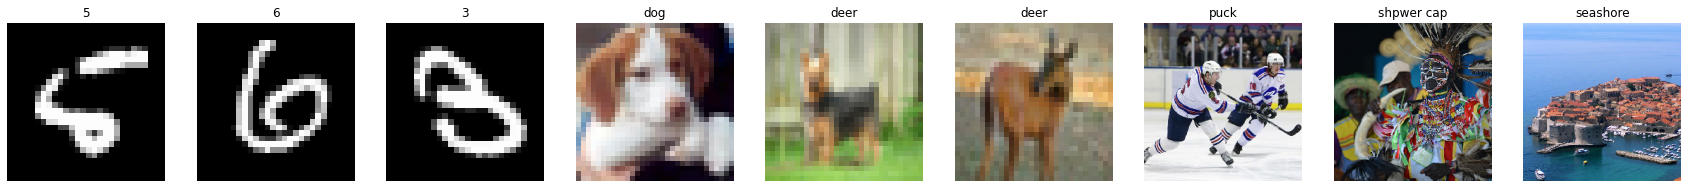

In [5]:
MNIST_test_idx = [8,11,18]
MNIST_y_hat = [5,6,3]
CIFAR_test_idx = [16,24,36]
CIFAR_y_hat = [5,4,4]
IMAGENET_test_idx = [3,7,9]
IMAGENET_y_hat = [746,793,978]
F,ax = plt.subplots(1,9,figsize=(30,3))

for i in range(9):
    ax[i].axis('off')

ax[0].imshow(MNIST_x_data_test[8:9,:].squeeze(0),cmap='gray')
ax[0].set_title('5')
ax[1].imshow(MNIST_x_data_test[11:12,:].squeeze(0),cmap='gray')
ax[1].set_title('6')
ax[2].imshow(MNIST_x_data_test[18:19,:].squeeze(0),cmap='gray')
ax[2].set_title('3')
ax[3].imshow(cifar_x_data[16:17,:].squeeze(0),cmap='gray')
ax[3].set_title('dog')
ax[4].imshow(cifar_x_data[24:25,:].squeeze(0),cmap='gray')
ax[4].set_title('deer')
ax[5].imshow(cifar_x_data[36:37,:].squeeze(0),cmap='gray')
ax[5].set_title('deer')
ax[6].imshow(imagenet_x_data[3:4,:].astype(int).squeeze(0))
ax[6].set_title('puck')
ax[7].imshow(imagenet_x_data[7:8,:].astype(int).squeeze(0))
ax[7].set_title('shpwer cap')
ax[8].imshow(imagenet_x_data[9:10,:].astype(int).squeeze(0))
ax[8].set_title('seashore');

First you need to run the explainer for a set of data and store the resulting scores. Then you use the following deletion/insertion algorithm

In [6]:
# The index set of data we tested for MNIST,Cifar and imagenet
np.random.seed(42)
img_idx = np.random.permutation(10000)[:100]
img_idx

array([6252, 4684, 1731, 4742, 4521, 6340,  576, 5202, 6363,  439, 2750,
       7487, 5272, 5653, 3999, 6033,  582, 9930, 7051, 8158, 9896, 2249,
       4640, 9485, 4947, 9920, 1963, 8243, 6590, 8847,  321, 2678, 4625,
       4949, 8328, 3337, 5589,  251, 3973, 6630, 5547,   35, 8362, 1513,
       9317,   39, 4819, 3465, 1760, 2304, 3723, 8284, 4993, 8127, 3032,
       7938, 3039, 9655, 2545, 2592, 1188, 7966, 6077,  107, 1315, 8187,
       2753, 9753, 6231, 2876, 5323,  799, 3570, 2894, 2927, 8178,  971,
       6687, 8575, 2020, 9054,  952, 5359, 3857, 5861, 3145, 3305, 3006,
       9001, 7770, 7438, 7942, 9238, 1056, 3154, 3787, 9189, 7825, 7539,
       7231])

# Deletion/Insertion images

In [7]:
import torch
SIZE = 224
HW = SIZE * SIZE # image area
CH = 3
n_classes = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
from torch import nn
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter

def gkern(klen, nsig):
    """Returns a Gaussian kernel array.
    Convolution with it results in image blurring."""
    # create nxn zeros
    inp = np.zeros((klen, klen))
    # set element at the middle to one, a dirac delta
    inp[klen//2, klen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    k = gaussian_filter(inp, nsig)
    kern = np.zeros((CH, CH, klen, klen))
    for i in range(CH):
        kern[i, i] = k
    return torch.from_numpy(kern.astype('float32'))

def auc(arr):
    """Returns normalized Area Under Curve of the array."""
    return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)

class CausalMetric():

    def __init__(self, model, mode, step, substrate_fn):
        r"""Create deletion/insertion metric instance.

        Args:
            model (nn.Module): Black-box model being explained.
            mode (str): 'del' or 'ins'.
            step (int): number of pixels modified per one iteration.
            substrate_fn (func): a mapping from old pixels to new pixels.
        """
        assert mode in ['del', 'ins']
        self.model = model
        self.mode = mode
        self.step = step
        self.substrate_fn = substrate_fn

    def single_run(self, img_tensor, explanation, verbose=0, save_to=None):
        r"""Run metric on one image-saliency pair.

        Args:
            img_tensor (Tensor): normalized image tensor.
            explanation (np.ndarray): saliency map.
            verbose (int): in [0, 1, 2].
                0 - return list of scores.
                1 - also plot final step.
                2 - also plot every step and print 2 top classes.
            save_to (str): directory to save every step plots to.

        Return:
            scores (nd.array): Array containing scores at every step.
        """
        pred = torch.tensor(self.model(img_tensor))
        top, c = torch.max(pred, 1)
        c = c[0]
        n_steps = (HW + self.step - 1) // self.step

        if self.mode == 'del':
            title = 'Deletion game'
            ylabel = 'Pixels deleted'
            start = torch.tensor(img_tensor).clone()
            finish = self.substrate_fn(torch.tensor(img_tensor))
        elif self.mode == 'ins':
            title = 'Insertion game'
            ylabel = 'Pixels inserted'
            start = self.substrate_fn(torch.tensor(img_tensor))
            finish = torch.tensor(img_tensor).clone()

        scores = np.empty(n_steps + 1)
        # Coordinates of pixels in order of decreasing saliency
        salient_order = np.flip(np.argsort(explanation.reshape(-1, HW), axis=1), axis=-1)
        for i in range(n_steps+1):
            pred = torch.tensor(self.model(start.numpy()))
            pr, cl = torch.topk(pred, 2)
            if verbose == 2:
                print('{}: {:.3f}'.format(get_class_name(cl[0][0]), float(pr[0][0])))
                print('{}: {:.3f}'.format(get_class_name(cl[0][1]), float(pr[0][1])))
            scores[i] = pred[0, c]
            # Render image if verbose, if it's the last step or if save is required.
            if verbose == 2 or (verbose == 1 and i == n_steps) or save_to:
                plt.figure(figsize=(10, 5))
                plt.subplot(121)
                plt.title('{} {:.1f}%, P={:.4f}'.format(ylabel, 100 * i / n_steps, scores[i]))
                plt.axis('off')
                #tensor_imshow(start[0])
                image = (start[0].detach().cpu().numpy()).astype(int)
                plt.imshow(np.stack([image[0,:,:],image[1,:,:],image[2,:,:]],axis=-1))

                plt.subplot(122)
                plt.plot(np.arange(i+1) / n_steps, scores[:i+1])
                plt.xlim(-0.1, 1.1)
                plt.ylim(0, 1.05)
                plt.fill_between(np.arange(i+1) / n_steps, 0, scores[:i+1], alpha=0.4)
                plt.title(title)
                plt.xlabel(ylabel)
                #plt.ylabel(get_class_name(c))
                if save_to:
                    plt.savefig(save_to + '/{:03d}.png'.format(i))
                    plt.close()
                else:
                    plt.show()
            if i < n_steps:
                coords = salient_order[:, self.step * i:self.step * (i + 1)]
                start.cpu().numpy().reshape(1, CH, HW)[0, :, coords] = finish.cpu().numpy().reshape(1, CH, HW)[0, :, coords]
        return scores

In [22]:
saliency_methods = ['LIME','eLRP','INTGRAD','deeplift','smoothgrad','XRAI','GradCAM','GradCAM++','RISE']

  0%|          | 0/1 [00:00<?, ?it/s]

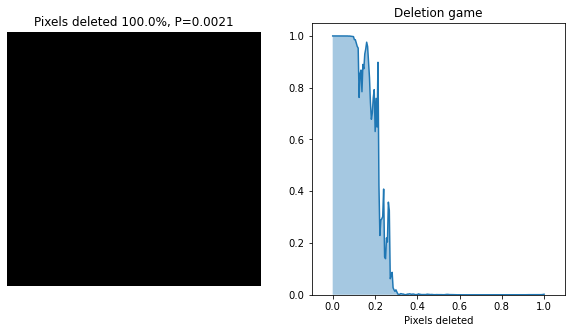

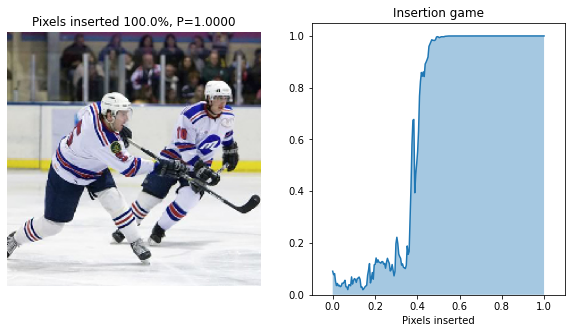

100%|██████████| 1/1 [01:21<00:00, 81.85s/it]


In [23]:
imagenet_VGG = load_data('imagenet')
deletion_scores = dict({})
insertion_scores = dict({})
def image_reshaping(image):
    if image.shape[1]==3:
        return np.stack([image[:,0,:,:],image[:,1,:,:],image[:,2,:,:]],axis=-1)
    elif image.shape[-1]==3:
        return np.stack([image[:,:,:,0],image[:,:,:,1],image[:,:,:,2]],axis=1)
    else:
        return image
    
for i in tqdm(range(1)):
    attributions = np.load('./Comparison_scores/Images/imagenet_'+saliency_methods[i]+'.npy').reshape(50,1,224,224)

    ### RISE ###
    class wrapper_model():
        def __init__(self, model):
            self.model = model
            
        def __call__(self, x):
            return self.model.predict(image_reshaping(x))
    wrapper_model = wrapper_model(imagenet_VGG)
    klen = 11 #how much blur
    ksig = 5 #how much defined are the border of the blur
    kern = gkern(klen, ksig)
    # Function that blurs input image
    blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)
    insertion = CausalMetric(wrapper_model, 'ins', SIZE, substrate_fn=blur)
    deletion  = CausalMetric(wrapper_model, 'del', SIZE, substrate_fn=torch.zeros_like)

    d = []
    ins = []
    
    for j in range(3,4):#len(img_idx)):
        img = image_reshaping(cifar_x_data[img_idx[j]:img_idx[j]+1])
        img = image_reshaping(imagenet_x_data[j:j+1,:])
        d.append(auc(deletion.single_run(img, attributions[j,:,:,:], verbose=1)))
        ins.append(auc(insertion.single_run(img, attributions[j,:,:,:], verbose=1)))
        
    deletion_scores[saliency_methods[i]] = d
    insertion_scores[saliency_methods[i]] = ins

#np.save('/content/drive/My Drive/XAI/XAI Survey/code/XAI_Scores/Images/comparison/imagenet_50_deletion',deletion_scores)
#np.save('/content/drive/My Drive/XAI/XAI Survey/code/XAI_Scores/Images/comparison/imagenet_50_insertion_blur',insertion_scores)

In [ ]:
deletion_scores

{'LIME': [0.2155924088304297]}

In [ ]:
insertion_scores

{'LIME': [0.5940592224436577]}

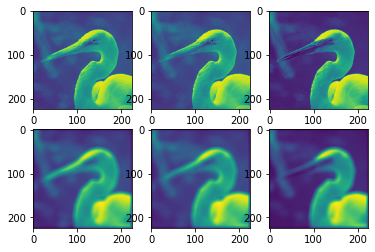

In [ ]:
CH = 3
def gkern(klen, nsig):
    """Returns a Gaussian kernel array.
    Convolution with it results in image blurring."""
    # create nxn zeros
    inp = np.zeros((klen, klen))
    # set element at the middle to one, a dirac delta
    inp[klen//2, klen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    k = gaussian_filter(inp, nsig)
    kern = np.zeros((CH, CH, klen, klen))
    for i in range(CH):
        kern[i, i] = k
    return torch.from_numpy(kern.astype('float32'))
def image_reshaping(image):
    if image.shape[1]==3:
        return np.stack([image[:,0,:,:],image[:,1,:,:],image[:,2,:,:]],axis=-1)
    elif image.shape[-1]==3:
        return np.stack([image[:,:,:,0],image[:,:,:,1],image[:,:,:,2]],axis=1)
    else:
        return image
j = 1
#img = image_reshaping((cifar_x_data[img_idx[j]:img_idx[j]+1]))
img = image_reshaping(imagenet_x_data[j:j+1,:])
klen = 11
ksig = 5
kern = gkern(klen, ksig)
# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)
F,ax = plt.subplots(2,3)
ax[0,0].imshow(img[0,0,:,:])
ax[0,1].imshow(img[0,1,:,:])
ax[0,2].imshow(img[0,2,:,:])
ax[1,0].imshow(blur(torch.tensor(img))[0,0,:])
ax[1,1].imshow(blur(torch.tensor(img))[0,1,:])
ax[1,2].imshow(blur(torch.tensor(img))[0,2,:])

In [ ]:
for k in insertion_scores.keys():
    print(k,np.mean(insertion_scores[k]))

LIME 0.3493232464376812
eLRP 0.05792999974497642
INTGRAD 0.1428870648924579
deeplift 0.05882320124560973
smoothgrad 0.20240346075299548
XRAI 0.23712997851429207
GradCAM 0.07394620682772618
GradCAM++ 0.20040987650306513
RISE 0.2940124935303046


In [ ]:
for k in deletion_scores.keys():
    print(k,np.mean(deletion_scores[k]))

LIME 0.05126435329434905
eLRP 0.014760248056475935
INTGRAD 0.029689488871894792
deeplift 0.014336031019768354
smoothgrad 0.03352455757417691
XRAI 0.0859766420198329
GradCAM 0.13969533488592212
GradCAM++ 0.08179195998817795
RISE 0.04422635002079354


In [ ]:
import numpy as np
data = np.load('/content/drive/My Drive/XAI/XAI Survey/code/XAI_Scores/text/comparison/YELP_BERT_deletion.npy',allow_pickle=True)

In [ ]:
d = dict(enumerate(data.flatten()))[0]
for k in d.keys():
    print(np.std(d[k]))

0.33984877370687233
0.3352805052932732
0.30246458564773915
0.3125966809147194


# Deletion/Insertion text

In [ ]:
!pip install transformers==2.7.0 urllib3==1.25.4 folium==0.2.1

In [ ]:
from torch import nn
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import torch

HW = 256 # image area
CH = 768
n_classes = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def auc(arr):
    """Returns normalized Area Under Curve of the array."""
    return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)

class CausalMetric():

    def __init__(self, model, mode, step, substrate_fn):
        r"""Create deletion/insertion metric instance.

        Args:
            model (nn.Module): Black-box model being explained.
            mode (str): 'del' or 'ins'.
            step (int): number of pixels modified per one iteration.
            substrate_fn (func): a mapping from old pixels to new pixels.
        """
        assert mode in ['del', 'ins']
        self.model = model
        self.mode = mode
        self.step = step
        self.substrate_fn = substrate_fn

    def single_run(self, text_input, explanation):
        
        pred = self.model(text_input).numpy()
        c = np.argmax(pred, 1)[0]
        n_steps = (HW + self.step - 1) // self.step

        if self.mode == 'del':
            title = 'Deletion game'
            ylabel = 'Pixels deleted'
            start = text_input.clone()
            finish = self.substrate_fn(text_input)
        elif self.mode == 'ins':
            title = 'Insertion game'
            ylabel = 'Pixels inserted'
            start = self.substrate_fn(text_input)
            finish = text_input.clone()

        scores = np.empty(n_steps + 1)
        # Coordinates of pixels in order of decreasing saliency
        salient_order = np.flip(np.argsort(explanation.reshape(-1, HW), axis=1), axis=-1)
        for i in range(n_steps+1):
            pred = self.model(start).numpy()
            scores[i] = pred[0, c]
            if i < n_steps:
                coords = salient_order[:, self.step*i : self.step*(i+1)]
                start[0, coords.ravel(), :] = finish[0, coords.ravel(), :]
        return scores

#    def evaluate(self, img_batch, exp_batch, batch_size):
#        r"""Efficiently evaluate big batch of images.
#
#        Args:
#            img_batch (Tensor): batch of images.
#            exp_batch (np.ndarray): batch of explanations.
#            batch_size (int): number of images for one small batch.
#
#        Returns:
#            scores (nd.array): Array containing scores at every step for every image.
#        """
#        n_samples = img_batch.shape[0]
#        predictions = torch.FloatTensor(n_samples, n_classes)
#        assert n_samples % batch_size == 0
#        for i in tqdm(range(n_samples // batch_size), desc='Predicting labels'):
#            preds = self.model(img_batch[i*batch_size:(i+1)*batch_size])
#            predictions[i*batch_size:(i+1)*batch_size] = preds
#        top = np.argmax(predictions, -1)
#        n_steps = (HW + self.step - 1) // self.step
#        scores = np.empty((n_steps + 1, n_samples))
#        salient_order = np.flip(np.argsort(exp_batch.reshape(-1, HW), axis=1), axis=-1)
#        r = np.arange(n_samples).reshape(n_samples, 1)
#
#        substrate = torch.zeros_like(torch.tensor(img_batch))
#        for j in tqdm(range(n_samples // batch_size), desc='Substrate'):
#            substrate[j*batch_size:(j+1)*batch_size] = self.substrate_fn(img_batch[j*batch_size:(j+1)*batch_size])
#
#        if self.mode == 'del':
#            caption = 'Deleting  '
#            start = img_batch.clone()
#            finish = substrate
#        elif self.mode == 'ins':
#            caption = 'Inserting '
#            start = substrate
#            finish = img_batch.clone()
#
#        # While not all pixels are changed
#        for i in tqdm(range(n_steps+1), desc=caption + 'pixels'):
#            # Iterate over batches
#            for j in range(n_samples // batch_size):
#                # Compute new scores
#                preds = self.model(start[j*batch_size:(j+1)*batch_size].numpy()).numpy()
#                preds = preds[range(batch_size), top[j*batch_size:(j+1)*batch_size]]
#                scores[i, j*batch_size:(j+1)*batch_size] = preds
#            # Change specified number of most salient pixels to substrate pixels
#            coords = salient_order[:, self.step * i:self.step * (i + 1)]
#            start.cpu().numpy().reshape(n_samples, 3, HW)[r, :, coords] = finish.cpu().numpy().reshape(n_samples, 3, HW)[r, :, coords]
#        print('AUC: {}'.format(auc(scores.mean(1))))
#        return scores

In [ ]:
rnd = 42
import random
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

dataset = 'IMDB'

def load_dataset(path):
    data = pd.read_csv(path)
    X = data['sentence'].values.tolist()
    Y = data['label'].values
    return X, Y

def sst_binary(data_dir='./data/'):
    """
    Stanford Sentiment Treebank.
    """
    trX, trY = load_dataset(os.path.join(data_dir, 'train_binary_sent.csv'))
    vaX, vaY = load_dataset(os.path.join(data_dir, 'dev_binary_sent.csv'))
    teX, teY = load_dataset(os.path.join(data_dir, 'test_binary_sent.csv'))
    return trX+vaX, teX, np.hstack((trY,vaY)), teY

def yelp_binary(data_dir='./data/'):
    """
    Yelp Review Polarity Dataset.
    """
    trX, trY = load_dataset(os.path.join(data_dir, 'train.csv'))
    teX, teY = load_dataset(os.path.join(data_dir, 'test.csv'))
    return trX, teX, trY, teY

def imdb_binary(data_dir='./data/'):
    """
    Imdb Review Polarity Dataset.
    """
    trX, trY = load_dataset(os.path.join(data_dir, 'train.csv'))
    teX, teY = load_dataset(os.path.join(data_dir, 'test.csv'))
    return trX, teX, trY, teY

SST_PATH  = '/content/drive/My Drive/XAI/XAI Survey/code/data/text/SST'
IMDB_PATH = '/content/drive/My Drive/XAI/XAI Survey/code/data/text/imdb_review_polarity/'
YELP_PATH = '/content/drive/My Drive/XAI/XAI Survey/code/data/text/yelp_review_polarity/'

if dataset == 'SST':
    trX, teX, trY, teY = sst_binary(SST_PATH)
    print('SST dataset selected')
elif dataset == 'IMDB':
    trX, teX, trY, teY = imdb_binary(IMDB_PATH)
    print('IMDB dataset selected')
elif dataset == 'YELP':
    trX, teX, trY, teY = yelp_binary(YELP_PATH)
    print('YELP dataset selected')

import requests

from tqdm import tqdm

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            with tqdm(unit='B', unit_scale=True, unit_divisor=1024) as bar:
                for chunk in response.iter_content(CHUNK_SIZE):
                    if chunk:  # filter out keep-alive new chunks
                        f.write(chunk)
                        bar.update(CHUNK_SIZE)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

if dataset == 'SST':
    download_file_from_google_drive('1RdM5-KkFuwrfv8luWoCyepBPleiNw3Py','SST_BERT.tgz')
    os.system('tar -zxvf SST_BERT.tgz')
elif dataset == 'IMDB':
    download_file_from_google_drive('1LwCSzbg6mts9AzuLHikoZou42-ixUuq9','IMDB_BERT.tgz')
    os.system('tar -zxvf IMDB_BERT.tgz')
elif dataset == 'YELP':
    download_file_from_google_drive('1udzt-GXMKzVmXxUxzYNZ7MjL7z8JcI5P','YELP_BERT.tar.gz')
    os.system('tar -zxvf YELP_BERT.tar.gz')
    os.system('mv /content/content/YELP_BERT/ /content/YELP_BERT')
    os.system('rm -r /content/content')

DEVICE = 'cuda'

BERT_TOKENIZER_PATH = './'+dataset+'_BERT/BERT_base_uncased_tokenizer.pt'
BERT_PATH = './'+dataset+'_BERT/BERT_base_uncased.pt'
BERT_FT_PATH = './'+dataset+'_BERT/'+dataset+'_BERT_FT.pt'

BERT_tokenizer = torch.load(BERT_TOKENIZER_PATH)
BERT = torch.load(BERT_PATH)

class FT_BERT(torch.nn.Module):

  def __init__(self, BERT_model, tokenizer):
    super(FT_BERT, self).__init__()
    self.BERT = BERT_model
    self.drop = torch.nn.Dropout(0.1)
    self.linear = torch.nn.Linear(768, 2)
    self.log_probs = torch.nn.LogSoftmax(dim=-1)
    self.tokenizer = tokenizer

  def forward(self, input_embeds):
    #inputs = self.tokenizer.batch_encode_plus(X, add_special_tokens=True, max_length=256, pad_to_max_length=True)
    #input_ids = np.vstack(inputs['input_ids'])
    #attention_mask = np.vstack(inputs['attention_mask'])
    #token_type_ids = np.vstack(inputs['token_type_ids'])
    outputs = self.log_probs(self.linear(self.drop(self.BERT(inputs_embeds=input_embeds)[1])))
    return torch.exp(outputs)

  def init_weights(self):
    torch.nn.init.normal_(self.linear.weight, mean=0.0, std=0.02)
    torch.nn.init.constant_(self.linear.bias,0)

from torch.utils import data

class TextDataset(data.Dataset):
  def __init__(self,trX,trY):
    self.trX = trX
    self.trY = trY

  def __len__(self):
    return len(self.trY)

  def __getitem__(self, idx):
    return (self.trX[idx],torch.tensor(self.trY[idx]))

train_data = TextDataset(trX, trY)
test_data = TextDataset(teX, teY)
train_data_loader = data.DataLoader(train_data, batch_size=32, shuffle=True)
test_data_loader = data.DataLoader(test_data, batch_size=32, shuffle=False)

model = FT_BERT(BERT,BERT_tokenizer).to(DEVICE)
device = torch.device(DEVICE)
model.load_state_dict(torch.load(BERT_FT_PATH,map_location=device))

IMDB dataset selected



0.00B [00:00, ?B/s]
8.91MB [00:00, 93.4MB/s]
40.0MB [00:00, 117MB/s] 
66.2MB [00:00, 142MB/s]
90.6MB [00:00, 164MB/s]
115MB [00:00, 184MB/s] 
142MB [00:00, 206MB/s]
173MB [00:00, 231MB/s]
203MB [00:00, 250MB/s]
233MB [00:00, 267MB/s]
260MB [00:01, 260MB/s]
286MB [00:01, 245MB/s]
314MB [00:01, 256MB/s]
343MB [00:01, 268MB/s]
369MB [00:01, 248MB/s]
398MB [00:01, 261MB/s]
426MB [00:01, 270MB/s]
452MB [00:01, 259MB/s]
479MB [00:01, 264MB/s]
504MB [00:02, 253MB/s]
532MB [00:02, 263MB/s]
560MB [00:02, 266MB/s]
586MB [00:02, 245MB/s]
614MB [00:02, 259MB/s]
641MB [00:02, 266MB/s]
667MB [00:02, 232MB/s]
694MB [00:02, 245MB/s]
720MB [00:02, 245MB/s]
748MB [00:03, 257MB/s]
774MB [00:03, 255MB/s]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch

<All keys matched successfully>

In [ ]:
class wrapper_model():
    def __init__(self, model):
        self.model = model
        
    def __call__(self, input_embeddings):
        return model(input_embeddings).detach().cpu()

wrapper_model = wrapper_model(model)
wrapper_model.model.eval()
wrapper_model.model.zero_grad()

In [ ]:
import pickle
deletion_scores = dict({})
insertion_scores = dict({})
    
saliency_methods = ['INTGRAD','LIME','deeplift','gradientxinput']

def pad_sub(x):
    return wrapper_model.model.BERT.embeddings(torch.zeros(1,256).long().to(DEVICE))

debug = []

for i in tqdm(range(len(saliency_methods))):
    attributions = pickle.load(open('/content/drive/My Drive/XAI/XAI Survey/code/XAI_Scores/text/'+saliency_methods[i]+'_'+dataset+'_BERT.pck','rb'))

    # Function that blurs input image
    insertion = CausalMetric(wrapper_model, 'ins', 10, substrate_fn = pad_sub)
    deletion  = CausalMetric(wrapper_model, 'del', 10, substrate_fn = pad_sub)

    d = []
    ins = []
    
    for j in range(100):
        inputs = BERT_tokenizer.batch_encode_plus([teX[j]], add_special_tokens=False, max_length=256, pad_to_max_length=True)
        input_ids = np.vstack(inputs['input_ids'])
        input_embeddings = wrapper_model.model.BERT.embeddings(torch.tensor(input_ids).to(DEVICE))
        if saliency_methods[i]=='LIME':
            index = np.argsort(np.array([attributions[j][k][1] for k in range(len(attributions[j]))]).astype(np.float).astype(int))
            tokens = np.array([attributions[j][k][0] for k in range(len(attributions[j]))])[index]
            scores = np.array([attributions[j][k][2] for k in range(len(attributions[j]))]).astype(np.float)[index]
            scores = np.pad(scores,(0,256-len(scores)))
        else:
            scores = np.pad(attributions[j],(0,256-len(attributions[j])))

        d.append(auc(deletion.single_run(input_embeddings, scores)))
        ins.append(auc(insertion.single_run(input_embeddings, scores)))
        debug.append(scores)

    deletion_scores[saliency_methods[i]] = d
    insertion_scores[saliency_methods[i]] = ins

np.save('/content/drive/My Drive/XAI/XAI Survey/code/XAI_Scores/text/comparison/'+dataset+'_BERT_deletion',deletion_scores)
np.save('/content/drive/My Drive/XAI/XAI Survey/code/XAI_Scores/text/comparison/'+dataset+'_BERT_insertion',insertion_scores)


100%|██████████| 4/4 [10:05<00:00, 151.31s/it]


In [ ]:
for k in insertion_scores.keys():
    print(k,np.mean(insertion_scores[k]))

INTGRAD 0.6469976844613511
LIME 0.6481936337826595
deeplift 0.600097147665488
gradientxinput 0.6306797879701481


In [ ]:
for k in deletion_scores.keys():
    print(k,np.mean(deletion_scores[k]))

INTGRAD 0.6161332707963166
LIME 0.599274106532371
deeplift 0.6452264036968923
gradientxinput 0.6321133585236608
